Starting CSV read...
CSV read finished.
CSV read time: 4.75 seconds

Starting text cleaning...
Text cleaning finished.
Text cleaning time: 36.33 seconds

Starting VADER analysis and classification...
Using VADER classification threshold: 0.5
VADER analysis finished.
VADER analysis time: 117.56 seconds

Splitting data into train (80%) and test (20%) sets...
Train set size: 1280000
Test set size: 320000
Test set target distribution:
target
1    0.5
0    0.5
Name: proportion, dtype: float64

Evaluating VADER performance on the test set...

VADER Accuracy on Test Set: 0.6241

Generating Confusion Matrix Plot...
Displaying graphical confusion matrix...


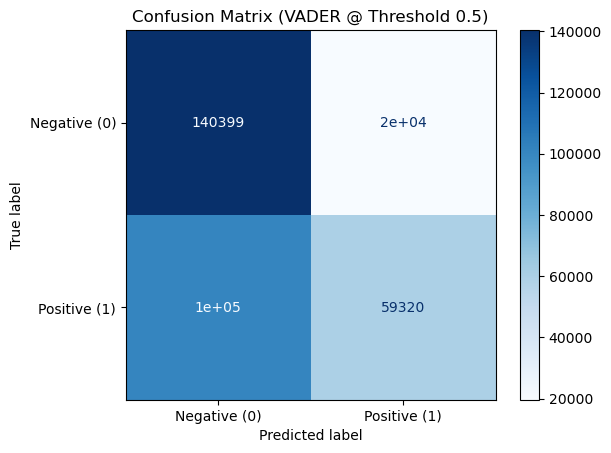

Confusion matrix plot closed.

Classification Report (Test Set):
              precision    recall  f1-score   support

Negative (0)       0.58      0.88      0.70    160000
Positive (1)       0.75      0.37      0.50    160000

    accuracy                           0.62    320000
   macro avg       0.67      0.62      0.60    320000
weighted avg       0.67      0.62      0.60    320000



In [1]:
import pandas as pd
import re
import time
import nltk
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import ConfusionMatrixDisplay


# --- Text Cleaning Function ---

emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B9"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F926-\U0001F937"
                           u"\U0001F1F2"
                           u"\U0001F6A9"
                           u"\u2640-\u2642"
                           u"\u2600-\u26FF"
                           u"\u2B50"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\u23f3"
                           u"\u200d"
                           u"\uFE0F"
                           "]+", flags=re.UNICODE)

contractions = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot",
    "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
    "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would", "he'll": "he will",
    "he's": "he is", "i'd": "i would", "i'll": "i will", "i'm": "i am",
    "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'll": "it will", "it's": "it is", "let's": "let us",
    "mustn't": "must not", "shan't": "shall not", "she'd": "she would",
    "she'll": "she will", "she's": "she is", "shouldn't": "should not",
    "that's": "that is", "there's": "there is", "they'd": "they would",
    "they'll": "they will", "they're": "they are", "they've": "they have",
    "we'd": "we would", "we'll": "we will", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what're": "what are", "what's": "what is", "what've": "what have",
    "where's": "where is", "who'd": "who would", "who'll": "who will",
    "who're": "who are", "who's": "who is", "who've": "who have",
    "won't": "will not", "wouldn't": "would not", "you'd": "you would",
    "you'll": "you will", "you're": "you are", "you've": "you have"
}
contractions_pattern = re.compile(r'\b(' + '|'.join(contractions.keys()) + r')\b')


def clean_text_simplified(text):
    """Cleans text: removes URLs, mentions, emojis, extra spaces, expands contractions."""
    
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'(?:https?://|www\.)\S+', '', text) # Remove URLs
        text = re.sub(r'@\w+', '', text) # Remove mentions
        text = emoji_pattern.sub(r'', text) # Remove emojis

        # Expand contractions
        def expand_match(contraction):
            match = contraction.group(0)
            expand = contractions.get(match)
            return expand if expand else match
        if text:
            text = contractions_pattern.sub(expand_match, text)

        # Remove non-alphanumeric characters (keeping spaces) and extra spaces
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ""

# --- File Path ---
filepath = 'training.1600000.processed.noemoticon.csv' 

# --- CSV Reading ---
print("Starting CSV read...")
read_start_time = time.time()
try:
    df = pd.read_csv(
        filepath,
        encoding='latin1',
        header=None,
        usecols=[0, 5], # Read only target (0) and text (5) columns
        names=['target', 'text'], # Name the columns directly
        dtype={'target': 'int8', 'text': 'string'} # Specify dtypes for speed and memory
                                                # using pandas 'string' type is often better than 'object'
    )
    read_end_time = time.time()
    read_run_time = read_end_time - read_start_time
    print("CSV read finished.")
    print(f"CSV read time: {read_run_time:.2f} seconds")

    # --- Modify Target Column ---
    if 'target' in df.columns:
        df['target'] = df['target'].replace(4, 1).astype('int8')
    else:
        print("Error: 'target' column not found.")
        df = None
except FileNotFoundError:
    print(f"Error: File not found at {filepath}")
    df = None
except Exception as e:
    print(f"Error reading or processing CSV: {e}")
    df = None

if df is not None:
    # --- Text Cleaning ---
    apply_method = df['text'].apply

    print("\nStarting text cleaning...")
    clean_start_time = time.time()

    if 'text' in df.columns:
        df['text'] = df['text'].fillna('')
        df['cleaned_text'] = apply_method(lambda x: clean_text_simplified(x))
    else:
        print("Error: 'text' column not found during cleaning.")
        df = None # Stop processing

    if df is not None:
        clean_end_time = time.time()
        clean_run_time = clean_end_time - clean_start_time
        print("Text cleaning finished.")
        print(f"Text cleaning time: {clean_run_time:.2f} seconds")

        # --- VADER Sentiment Analysis ---
        print("\nStarting VADER analysis and classification...")
        vader_start_time = time.time()

        CLASSIFICATION_THRESHOLD = 0.5
        print(f"Using VADER classification threshold: {CLASSIFICATION_THRESHOLD}")

        analyzer = SentimentIntensityAnalyzer()

        # Function to get VADER compound score more robustly
        def get_vader_compound(text):
            # VADER works directly on strings, check type
            if isinstance(text, str):
                try:
                    return analyzer.polarity_scores(text)['compound']
                except Exception as e:
                    # Handle potential errors within VADER on weird strings if they slip through
                    print(f"VADER error on text: '{text[:50]}...'. Error: {e}")
                    return 0.0 # Assign neutral on error
            else:
                return 0.0 # Assign neutral for non-strings

        apply_method_vader = df['cleaned_text'].apply

        df['vader_compound'] = apply_method_vader(get_vader_compound)

        # Classify based on threshold
        df['vader_sentiment'] = df['vader_compound'].apply(
            lambda score: 1 if score >= CLASSIFICATION_THRESHOLD else 0
        ).astype('int8')

        vader_end_time = time.time()
        vader_run_time = vader_end_time - vader_start_time
        print(f"VADER analysis finished.")
        print(f"VADER analysis time: {vader_run_time:.2f} seconds")
        # --- End VADER Section ---

        #Drop columns to save memory before splitting
        df = df.drop(columns=['text', 'cleaned_text', 'vader_compound'], errors='ignore')

        # --- Split Data for Evaluation ---
        print("\nSplitting data into train (80%) and test (20%) sets...")
        try:
            train_df, test_df = train_test_split(
                df,
                test_size=0.20,
                random_state=34, # Keep consistent random state
                stratify=df['target'] # Stratify by the target variable
            )
            print(f"Train set size: {len(train_df)}")
            print(f"Test set size: {len(test_df)}")
            print(f"Test set target distribution:\n{test_df['target'].value_counts(normalize=True)}")

            # We don't need train_df for VADER evaluation, clear memory
            del train_df

        except Exception as e:
            print(f"Error during data splitting: {e}")
            test_df = None

        # --- === End Data Splitting === ---


        # --- === 3. Evaluate VADER on Test Set === ---
        if test_df is not None:
            print("\nEvaluating VADER performance on the test set...")

            y_true = test_df['target']
            y_pred = test_df['vader_sentiment']

            # Calculate Accuracy
            accuracy = accuracy_score(y_true, y_pred)
            print(f"\nVADER Accuracy on Test Set: {accuracy:.4f}")

            # --- === Graphical Confusion Matrix (MODIFIED PART) === ---
            print("\nGenerating Confusion Matrix Plot...")
            # Calculate the confusion matrix
            cm = confusion_matrix(y_true, y_pred)

            # Define display labels based on your classes (0 and 1)
            display_labels = ['Negative (0)', 'Positive (1)']


            # Create the ConfusionMatrixDisplay object
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                          display_labels=display_labels)

            # Plot the matrix
            disp.plot(cmap=plt.cm.Blues) # Use a blue color map

            # Add a title to the plot
            plt.title(f"Confusion Matrix (VADER @ Threshold {CLASSIFICATION_THRESHOLD})")

            # Display the plot
            print("Displaying graphical confusion matrix...")
            plt.show() # This will open a window with the plot
            print("Confusion matrix plot closed.")

            # Calculate and Print Classification Report
            print("\nClassification Report (Test Set):")
            try:
                report = classification_report(y_true, y_pred, target_names=display_labels)
                print(report)
            except Exception as e:
                 print(f"Could not generate classification report: {e}")
        else:
            print("\nSkipping evaluation due to issues in data splitting.")
        # --- === End Evaluation === ---

# Final message if DataFrame processing failed earlier
else:
    print("\nCould not process the DataFrame. Evaluation aborted.")